In [60]:
# Import base packages
import os
import numpy as np
import pandas as pd
import ast
import csv
from collections import defaultdict

# Import Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image, ImageDraw

In [2]:
# Set up image folder locations
currdir = os.getcwd()
parentdir = os.path.abspath(os.path.join(currdir, os.pardir))
datadir = os.path.join(parentdir, 'data')
rawdir = os.path.join(datadir, 'raw')
traindir = os.path.join(rawdir, 'train')

In [3]:
# Number of Images
print("Number of Training Images: ", len(os.listdir(traindir)))

Number of Training Images:  3422


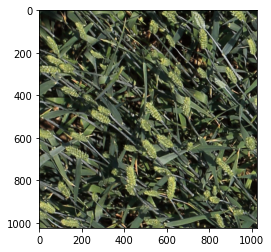

In [73]:
# Open a sample image
image_id = '0afdb91a2'
img = Image.open(os.path.join(traindir, image_id + '.jpg'))
plt.imshow(img)

In [74]:
# Read in the train.csv to understand it and set the image_id as the index
df = pd.read_csv(os.path.join(rawdir, 'train.csv'))
df.set_index("image_id", inplace = True)
display(df.shape, df.head(25))


(147793, 4)

,width,height,bbox,source
image_id,,,,
b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1
b6ab77fd7,1024,1024,"[569.0, 382.0, 119.0, 111.0]",usask_1
b6ab77fd7,1024,1024,"[52.0, 602.0, 82.0, 45.0]",usask_1
b6ab77fd7,1024,1024,"[627.0, 302.0, 122.0, 75.0]",usask_1
b6ab77fd7,1024,1024,"[412.0, 367.0, 68.0, 82.0]",usask_1


In [75]:
# Make sure all images are the same width and height. All images are the same width and height, 1024 px x 1024 px
print("Avg Width: ", df['width'].mean())
print("Avg Height: ", df['height'].mean())

# How many different sources do we get data from?
print("Unique Sources: ", df['source'].unique())

# Are there any missing values:
print("# of Missing Values: ", df.isna().sum())

# Number of unique image_ids
print("Unique Image Ids: ", len(df.index.unique()))

Avg Width:  1024.0
Avg Height:  1024.0
Unique Sources:  ['usask_1' 'arvalis_1' 'inrae_1' 'ethz_1' 'arvalis_3' 'rres_1' 'arvalis_2']
# of Missing Values:  width     0
height    0
bbox      0
source    0
dtype: int64
Unique Image Ids:  3373


In [76]:
# Convert the string in the bounding box to a list that can be iterated over
df['bbox'] = df['bbox'].apply(lambda row: ast.literal_eval(row))

# of Bounding Boxes:  60


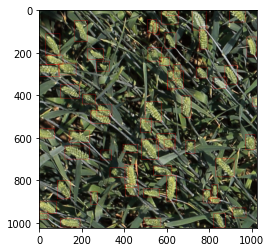

In [77]:
# Plot the bounding boxes on the image
bboxes = df.loc[image_id]['bbox'].tolist()
print("# of Bounding Boxes: ", len(bboxes))
for box in bboxes:
    x0, y0 = box[:2]
    x1 = box[0] + box[2]
    y1 = box[1] + box[3]

    draw = ImageDraw.Draw(img)
    draw.rectangle([(x0, y0), (x1, y1)], outline='red')

plt.imshow(img)

In [91]:
# Set up a data dictionary in such a way that each image has a list of bounding boxes. 
# Step 1: Get each image name (without the .jpg part) as the key of a dictionary in the traindir directory. We only care about the name of the image
# Step 2: Assign each image to an empty list which will be filled in with the bounding box data from train.csv file
# Step 3: Now open the train.csv file with the csv module
# Step 4: For each image_id which is the key of the dictionary, append the bounding boxes. The keys that are empty reference images that do not contain wheat in them. 

# Set up an empty dictionary
data = {}
for img_file in os.listdir(traindir):
    img_name = img_file.split('.')[0]
    data[img_name] = data.get(img_name, [])


with open(os.path.join(rawdir, 'train.csv')) as file:
    reader = csv.DictReader(file)
    for row in reader:
        data[row['image_id']].append(ast.literal_eval(row['bbox']))

In [96]:
# Show a sample set of bounding boxes and make sure it matches the length above
print("Length of bounding boxes: ", len(data[image_id]))
print(data[image_id])

Length of bounding boxes:  60
[[121.0, 638.0, 117.0, 62.0], [872.0, 259.0, 61.0, 89.0], [243.0, 472.0, 90.0, 60.0], [976.0, 126.0, 46.0, 90.0], [591.0, 106.0, 52.0, 74.0], [820.0, 954.0, 55.0, 68.0], [1001.0, 413.0, 23.0, 39.0], [719.0, 2.0, 66.0, 92.0], [481.0, 606.0, 80.0, 95.0], [604.0, 286.0, 74.0, 82.0], [30.0, 111.0, 68.0, 101.0], [498.0, 430.0, 76.0, 95.0], [165.0, 49.0, 61.0, 98.0], [553.0, 580.0, 87.0, 72.0], [0.0, 897.0, 82.0, 58.0], [141.0, 567.0, 97.0, 55.0], [752.0, 79.0, 41.0, 104.0], [830.0, 696.0, 86.0, 87.0], [100.0, 350.0, 89.0, 64.0], [596.0, 1.0, 61.0, 25.0], [671.0, 402.0, 43.0, 102.0], [538.0, 732.0, 85.0, 44.0], [812.0, 819.0, 26.0, 65.0], [100.0, 978.0, 92.0, 41.0], [333.0, 740.0, 85.0, 45.0], [895.0, 0.0, 73.0, 56.0], [271.0, 442.0, 71.0, 56.0], [243.0, 851.0, 30.0, 62.0], [599.0, 776.0, 46.0, 121.0], [738.0, 268.0, 52.0, 51.0], [817.0, 315.0, 62.0, 53.0], [535.0, 60.0, 29.0, 56.0], [969.0, 584.0, 45.0, 71.0], [0.0, 944.0, 42.0, 40.0], [33.0, 211.0, 79.0, 45.0]

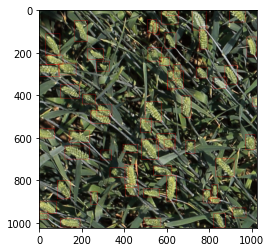

In [105]:
new_img = np.array(img).reshape((3, 1024, 1024))
plt.imshow(new_img.reshape((1024, 1024, 3)))

In [107]:
len(data)

3422